In [34]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
import numpy as np
from scipy import stats
import pylab as plt
import torch
import swyft
from simulators import SimulatorLinePattern

In [43]:
bounds = None
SIGMA = 0.3

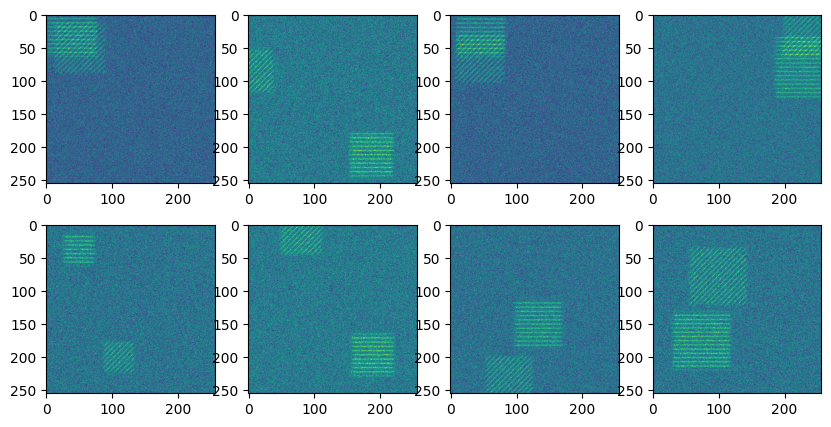

In [44]:
sim = SimulatorLinePattern(bounds = bounds, sigma = SIGMA)
plt.figure(figsize = (10, 5))
z0 = np.array([-0.6, -0.6, -0.7, -.8, 0.3])
#z0 = np.array([-0.2, -0.2, -0.4, -.4, 0.3])
sample0 = sim.sample(conditions = dict(z = z0))
mu0 = sample0['mu']
for i in range(1, 9):
    plt.subplot(2, 4, i)
    if i == 1:
        sample = sample0
    else:
        sample = sim.sample()
    x = sample['x']
    plt.imshow(x)

[8.79203403e-04 8.79200828e-04 1.23077529e-03 9.85574892e-05
 5.87474208e-04]


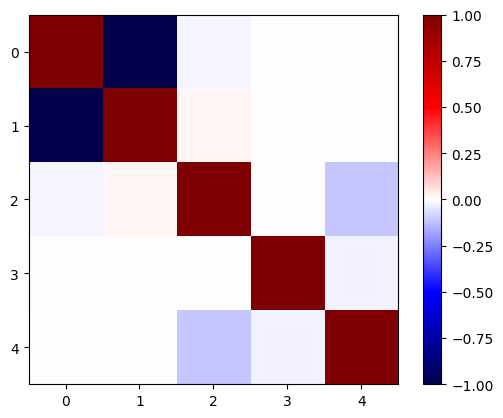

In [41]:
def fisher(z0, epsilon):
    dmu = []
    n = len(z0)
    for i in range(n):
        dz = np.zeros(len(z0))
        dz[i] = epsilon
        temp = sim.sample(conditions = dict(z = z0+dz))['mu'] - sim.sample(conditions = dict(z = z0))['mu']
        dmu.append(temp)
    Q = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            Q[i, j] = (dmu[i]*dmu[j]).sum()/epsilon**2
    return Q/sim.sigma**2

z0 = np.array([-0.6, -0.6, -0.7, -.8, 0.3])
Q = fisher(z0, 1e-4)
Cov = np.linalg.inv(Q)
std = np.diagonal(Cov)**0.5
Rho = np.diag(1/std).dot(Cov).dot(np.diag(1/std))
plt.imshow(Rho, vmin = -1, vmax = 1, cmap = 'seismic')
plt.colorbar()
print(std)

bounds = np.array([[z0[i]-10*std[i], z0[i]+10*std[i]] for i in range(5)])

In [57]:
class Network(swyft.SwyftModule):
    def __init__(self, prefix = ""):
        super().__init__()
        self.logratios = swyft.LogRatioEstimator_1dim(num_features = 4, num_params = 5, varnames = 'z',
                                                      dropout = 0.1, use_batch_norm = True, num_blocks = 4, hidden_features = 128)
        self.optimizer_init = swyft.AdamOptimizerInit(lr=1e-3, lrs_factor=0.3, lrs_patience=5)
        self.norm = swyft.networks.OnlineStandardizingLayer((256, 256))
        self.CNN = torch.nn.Sequential(
            torch.nn.LazyConv2d(4, 3), torch.nn.ReLU(), torch.nn.MaxPool2d(2), torch.nn.LazyBatchNorm2d(affine = False, momentum = 0.01),
            torch.nn.LazyConv2d(8, 3), torch.nn.ReLU(), torch.nn.MaxPool2d(2), torch.nn.LazyBatchNorm2d(affine = False, momentum = 0.01),
            torch.nn.LazyConv2d(16, 3), torch.nn.ReLU(), torch.nn.MaxPool2d(2), torch.nn.LazyBatchNorm2d(affine = False, momentum = 0.01),
            torch.nn.LazyConv2d(32, 3), torch.nn.ReLU(), torch.nn.MaxPool2d(2), torch.nn.LazyBatchNorm2d(affine = False, momentum = 0.01),
            torch.nn.LazyConv2d(64, 3), torch.nn.ReLU(), torch.nn.MaxPool2d(2), torch.nn.LazyBatchNorm2d(affine = False, momentum = 0.01),            
        )
        self.CNN_to_MLP = torch.nn.LazyLinear(1024)
        self.MLP = torch.nn.Sequential(
            swyft.networks.channelized.LinearWithChannel(5, 1024, 256), torch.nn.ReLU(),
            swyft.networks.channelized.LinearWithChannel(5, 256, 128), torch.nn.ReLU(),
            swyft.networks.channelized.LinearWithChannel(5, 128, 2)
        )
        
        self.linear_embedding = torch.nn.LazyLinear(10)

        self.prefix = ""

    def forward(self, A, B):
        x = A['x']

#        fx = torch.fft.fft2(x)
#        x = torch.stack([fx.real, fx.imag], dim=-1)
        x = self.norm(x)

        f1 = self.CNN(x.unsqueeze(1))
        f1 = self.CNN_to_MLP(torch.flatten(f1, start_dim = 1)).unsqueeze(1).expand(-1, 5, -1)
        f1 = self.MLP(f1).view(-1, 5, 2)
        f2 = self.linear_embedding(torch.flatten(x, start_dim=1)).view(-1, 5, 2)
        f = torch.cat([f1, f2], dim=-1)
       
        z = B[self.prefix+'z']
        
        logratios = self.logratios(f, z)
        return logratios, f, z
    
    def bounds(self, logratios):
        bounds = swyft.collect_rect_bounds(logratios, 'z', (5,), threshold = 1e-6)
        return bounds
    
net = Network()

In [46]:
# Simulate
# Infer + get bounds
Nsims = 1024
#randn_realizations = np.random.randn(10000, 256, 256)

# Simulate
sim = SimulatorLinePattern(bounds = bounds, sigma = SIGMA, randn_realizations = randn_realizations)
samples = sim.sample(Nsims)
prior_samples = sim.sample(N = 1000, targets = ['z'])


100%|███████████████████████████████████████████████████████████████████████████████████████| 1024/1024 [00:03<00:00, 269.18it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2098.99it/s]


In [58]:
resampler = sim.get_resampler(targets = ['x'])

In [59]:
trainer = swyft.SwyftTrainer(accelerator = 'gpu', max_epochs = 50, precision = 32)
net = Network(prefix="")  # Instantiate network
dl = swyft.SwyftDataModule(samples, fractions = [0.8, 0.2, 0], batch_size = 256, on_after_load_sample = resampler)
trainer.fit(net, dl)
logratios = trainer.infer(net, sample0, prior_samples)
#        bounds[prefix] = net.bounds(logratios)
#        bounds = bounds[prefix]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                     | Params
--------------------------------------------------------------
0 | logratios        | LogRatioEstimator_1dim   | 664 K 
1 | norm             | OnlineStandardizingLayer | 0     
2 | CNN              | Sequential               | 0     
3 | CNN_to_MLP       | LazyLinear               | 0     
4 | MLP              | Sequential               | 1.5 M 
5 | linear_embedding | LazyLinear

/home/cweniger/.pyenv/versions/3.10.11/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1600: PossibleUserWarning: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 0:  80%|█████████████████████████████████████████████████▌            | 4/5 [00:00<00:00,  8.42it/s, loss=-0.06, v_num=175]
Validation: 0it [00:00, ?it/s]
Epoch 1:  80%|██████████████████████████████████▍        | 4/5 [00:00<00:00,  8.79it/s, loss=-0.142, v_num=175, val_loss=0.00304]
Validation: 0it [00:00, ?it/s]
Epoch 2:  80%|██████████████████████████████████▍        | 4/5 [00:00<00:00,  8.84it/s, loss=-0.277, v_num=175, val_loss=0.00342]
Validation: 0it [00:00, ?it/s]
Epoch 3:  80%|██████████████████████████████████▍        | 4/5 [00:00<00:00,  8.39it/s, loss=-0.399, v_num=175, val_loss=0.00307]
Validation: 0it [00:00, ?it/s]
Epoch 4:  80%|███████████████████████████████████▏        | 4/5 [00:00<00:00,  8.35it/s, loss=-0.531, v_num=175, val_loss=0.0036]
Validation: 0it [00:00, ?it/s]
Epoch 5:  80%|███████████████████████████████████▏        | 4/5 [00:00<00:00,  8.54it/s, loss=-0.786, v_num=175, val_loss=0.0044]
Validation: 0it [00:00, ?it/s]
Epoch 6:  80%|████████████████████

You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 46.57it/s]


In [25]:
logratios2 = trainer.infer(net, samples, samples, return_sample_ratios = False, batch_size = 1024)

You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████| 8/8 [00:02<00:00,  3.47it/s]


### Batchnorm, 4 layers, 8k training, no dropout, no fft, no zoom

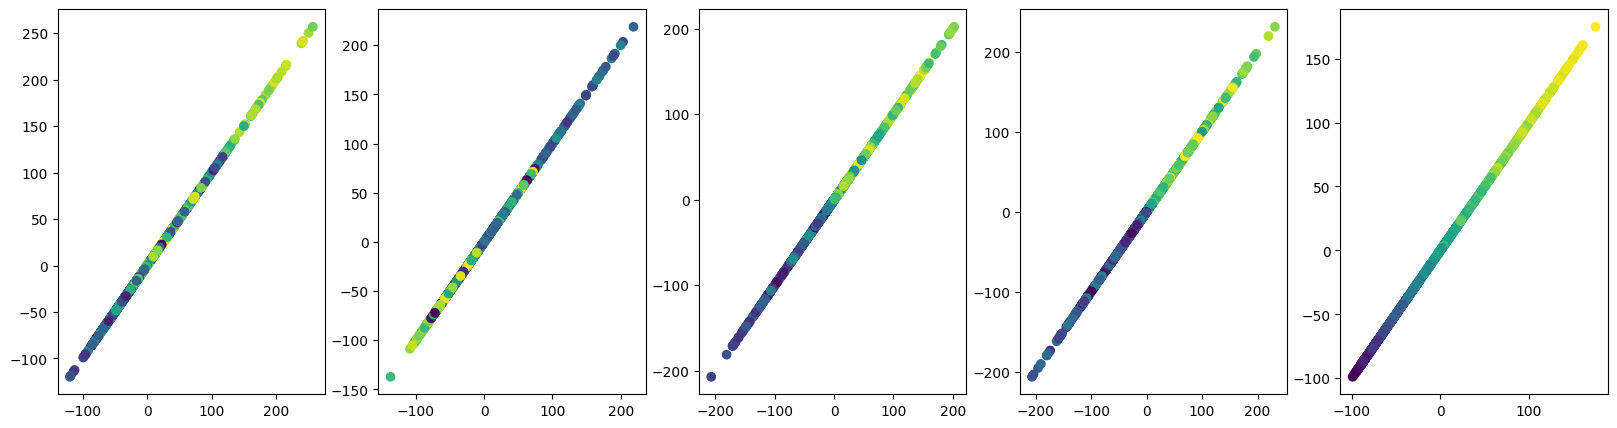

In [26]:
f = logratios2[0][1][:,:]
z = logratios2[0][2]
plt.figure(figsize=(20, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
#    plt.scatter(z[:,i], f[:,i,0])
    plt.scatter(f[:,i,0], f[:,i,0], c = z[:,i])

You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 74.09it/s]


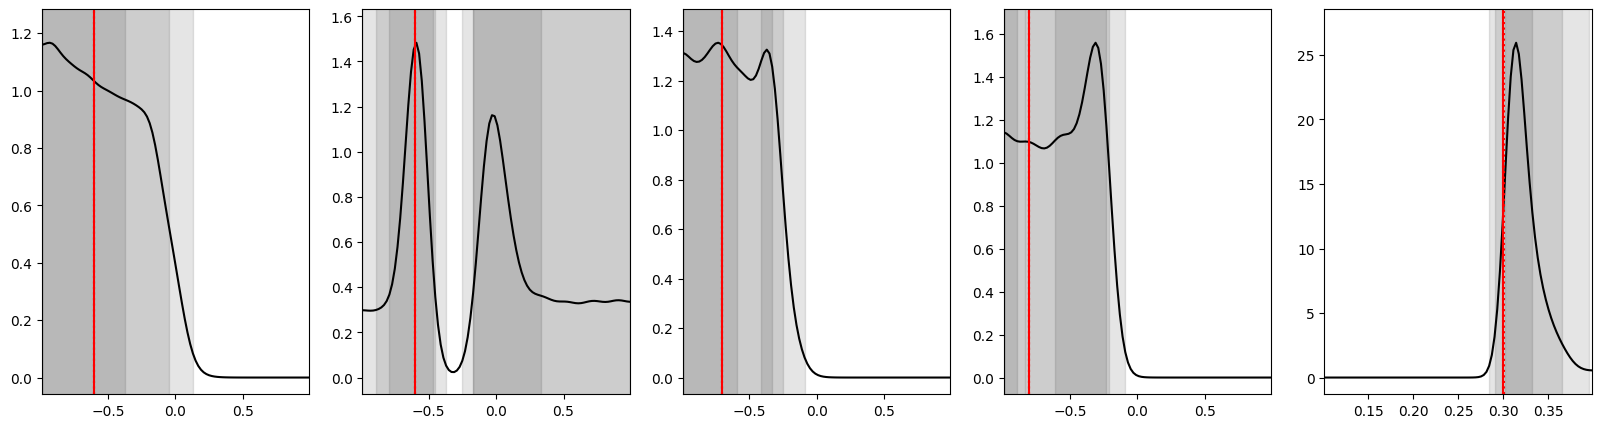

In [27]:
logratios = trainer.infer(net, sample0, prior_samples)


plt.figure(figsize = (20, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    j = i
    swyft.plot_1d(logratios, "z[%i]"%j, ax = plt.gca(), smooth = 3, bins = 100)
#    plt.gca().set_yscale('log')
#    plt.gca().set_ylim([1e-10, 1e2])
    plt.axvline(sample0['z'][j], c = 'r', ls='-')
    plt.axvline(sample0['z'][j]-std[j], c='r', ls=':')
    plt.axvline(sample0['z'][j]+std[j], c='r', ls=':')

### Batchnorm, 4 layers, 8k training, no dropout, no fft

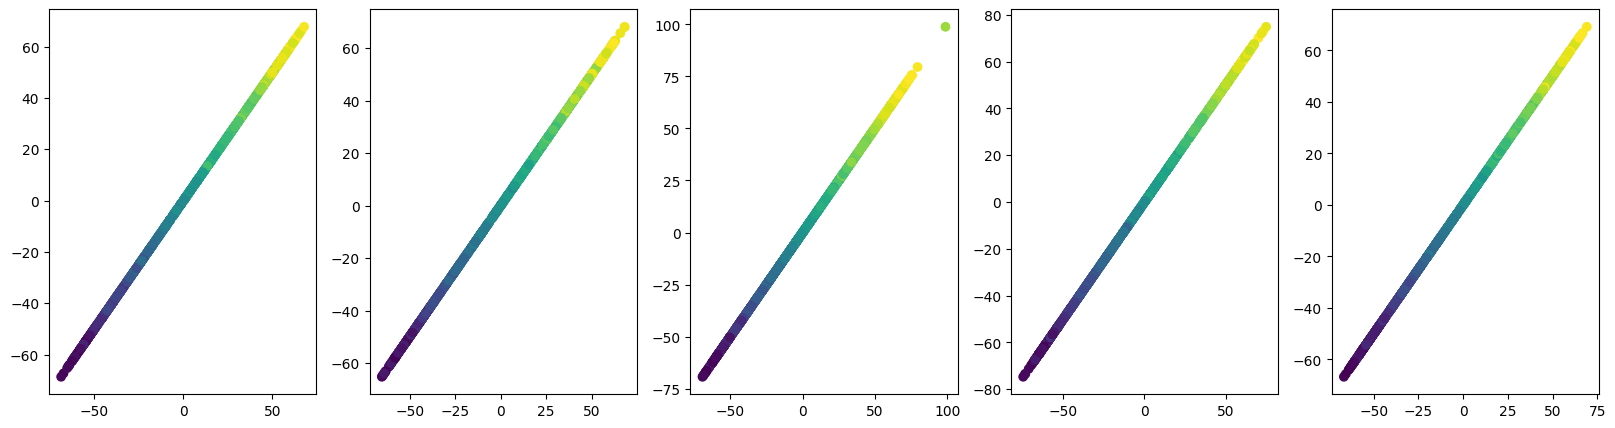

In [19]:
f = logratios2[0][1][:,:]
z = logratios2[0][2]
plt.figure(figsize=(20, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
#    plt.scatter(z[:,i], f[:,i,0])
    plt.scatter(f[:,i,0], f[:,i,0], c = z[:,i])

You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 77.51it/s]


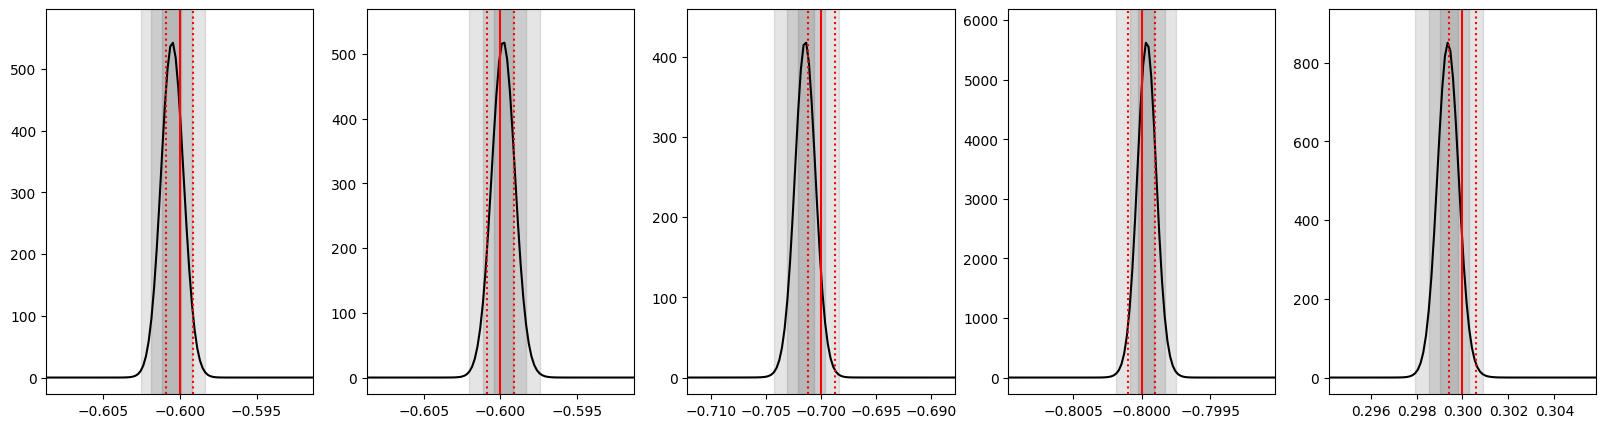

In [20]:
logratios = trainer.infer(net, sample0, prior_samples)


plt.figure(figsize = (20, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    j = i
    swyft.plot_1d(logratios, "z[%i]"%j, ax = plt.gca(), smooth = 3, bins = 100)
#    plt.gca().set_yscale('log')
#    plt.gca().set_ylim([1e-10, 1e2])
    plt.axvline(sample0['z'][j], c = 'r', ls='-')
    plt.axvline(sample0['z'][j]-std[j], c='r', ls=':')
    plt.axvline(sample0['z'][j]+std[j], c='r', ls=':')

### Batchnorm, 4 layers, 8k training, no dropout, fft

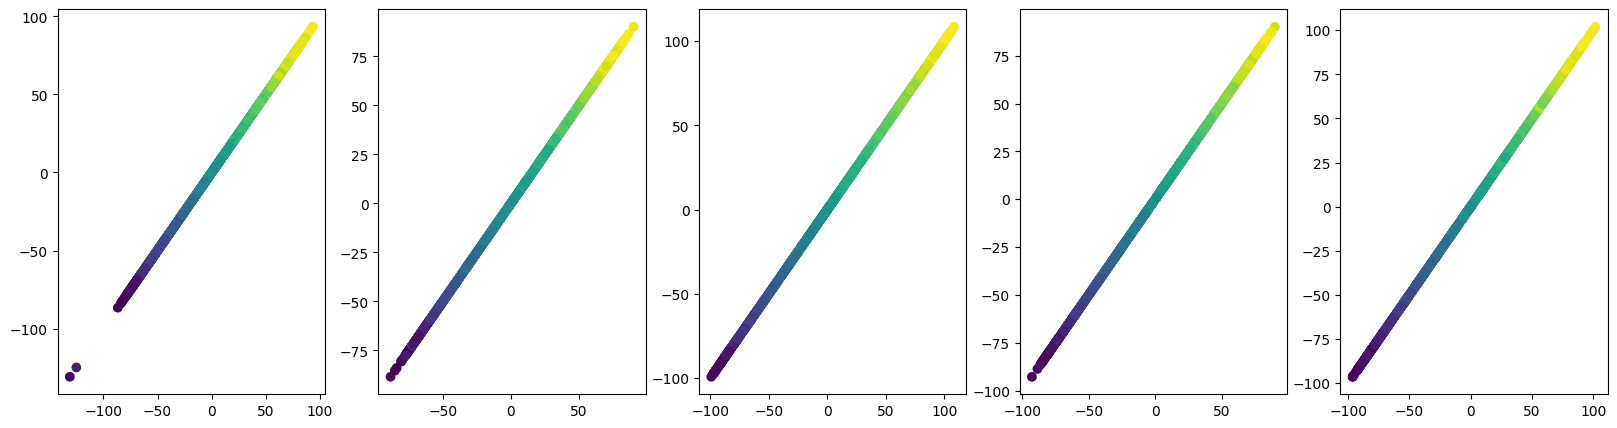

In [14]:
f = logratios2[0][1][:,:]
z = logratios2[0][2]
plt.figure(figsize=(20, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
#    plt.scatter(z[:,i], f[:,i,0])
    plt.scatter(f[:,i,0], f[:,i,0], c = z[:,i])

You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 88.43it/s]


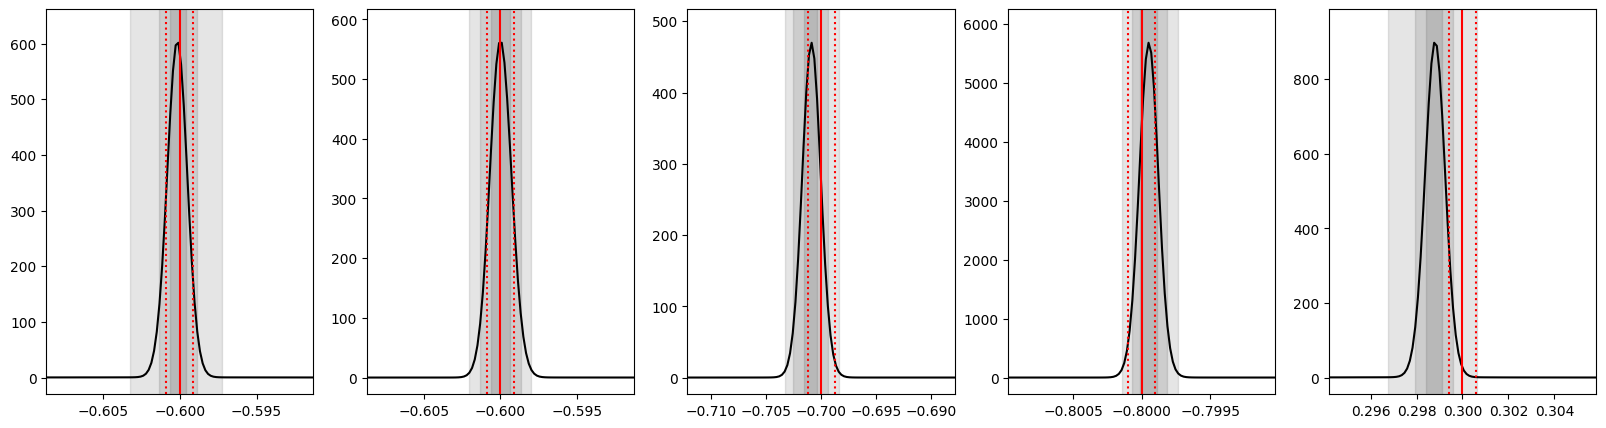

In [15]:
logratios = trainer.infer(net, sample0, prior_samples)


plt.figure(figsize = (20, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    j = i
    swyft.plot_1d(logratios, "z[%i]"%j, ax = plt.gca(), smooth = 3, bins = 100)
#    plt.gca().set_yscale('log')
#    plt.gca().set_ylim([1e-10, 1e2])
    plt.axvline(sample0['z'][j], c = 'r', ls='-')
    plt.axvline(sample0['z'][j]-std[j], c='r', ls=':')
    plt.axvline(sample0['z'][j]+std[j], c='r', ls=':')

### Batchnorm, 4 layers, 2k training, no dropout, round 2

Epoch 2:  98%|███████████████████████████████████████████▎| 64/65 [03:58<00:03,  3.73s/it, loss=-2.77, v_num=155, val_loss=-.443]

Epoch 31:  83%|███████████████████████████████████▋       | 54/65 [01:58<00:24,  2.20s/it, loss=-2.86, v_num=156, val_loss=-1.31]

                                                                                                                                 

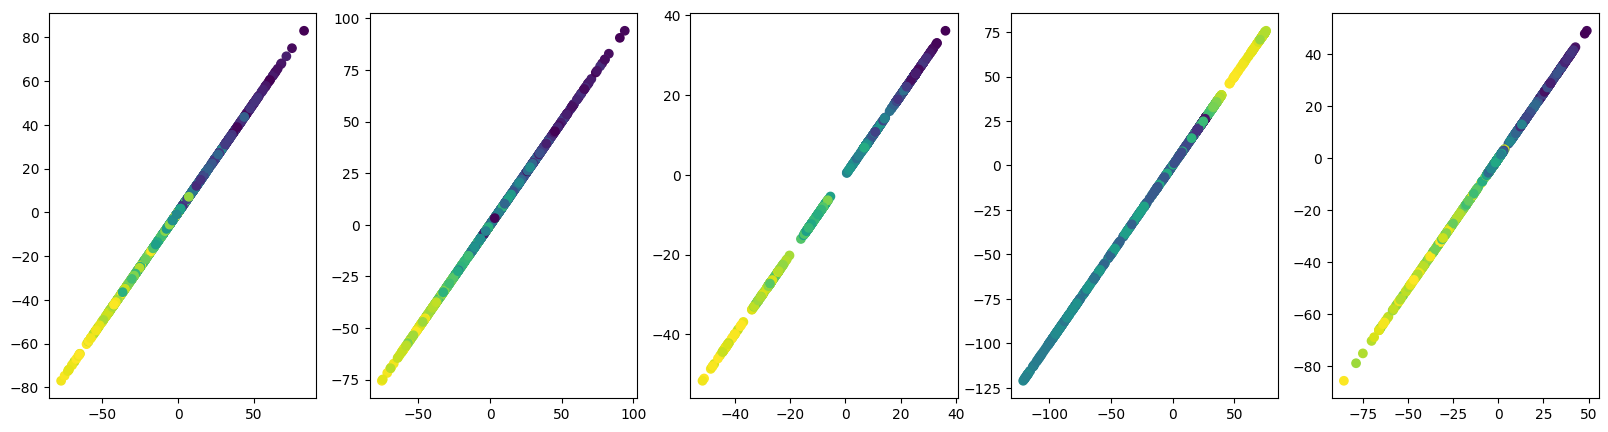

In [203]:
f = logratios2[0][1][:,:]
z = logratios2[0][2]
plt.figure(figsize=(20, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
#    plt.scatter(z[:,i], f[:,i,0])
    plt.scatter(f[:,i,0], f[:,i,0], c = z[:,i])

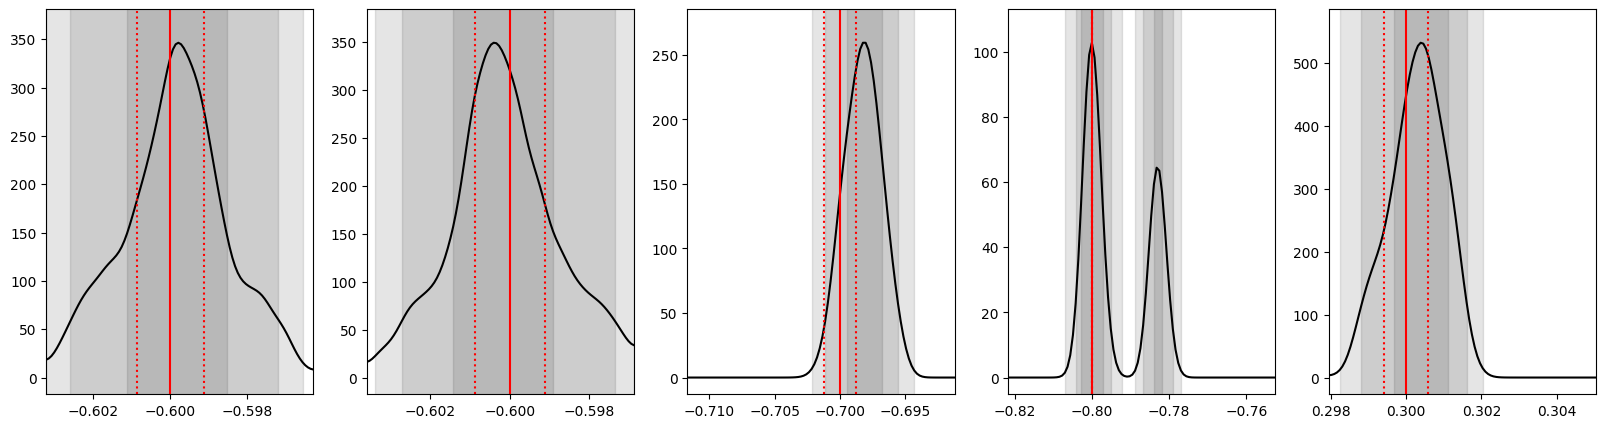

In [315]:
plt.figure(figsize = (20, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    j = i
    swyft.plot_1d(logratios, "z[%i]"%j, ax = plt.gca(), smooth = 3, bins = 100)
#    plt.gca().set_yscale('log')
#    plt.gca().set_ylim([1e-10, 1e2])
    plt.axvline(sample0['z'][j], c = 'r', ls='-')
    plt.axvline(sample0['z'][j]-std[j], c='r', ls=':')
    plt.axvline(sample0['z'][j]+std[j], c='r', ls=':')


### Batchnorm, 4 layers, 2k training, no dropout

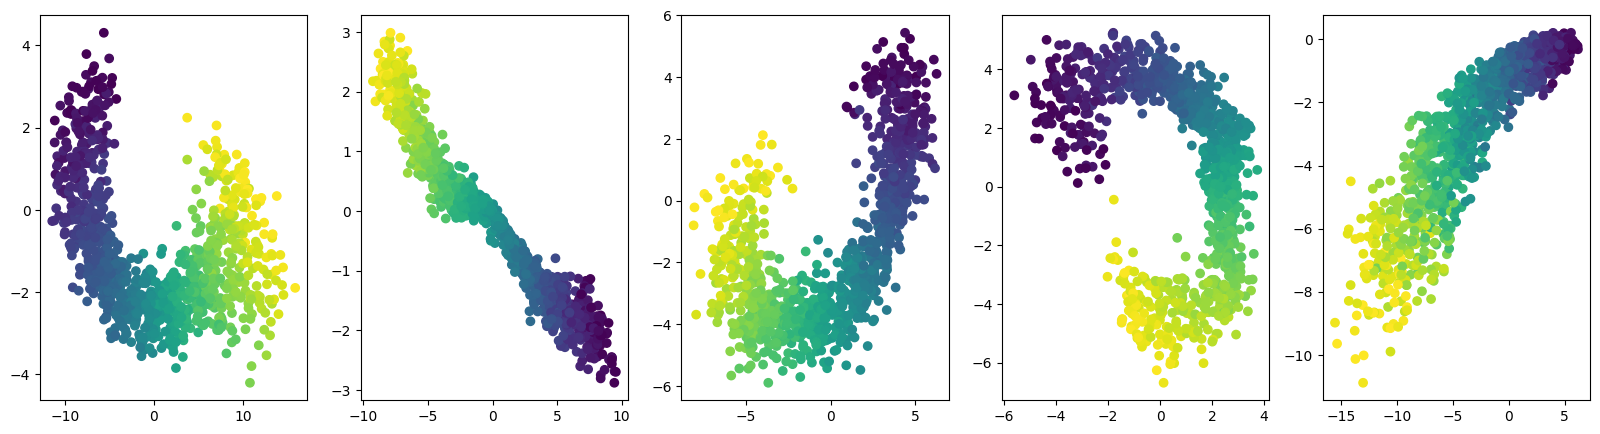

In [29]:
f = logratios2[0][1][:,:]
z = logratios2[0][2]
plt.figure(figsize=(20, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
#    plt.scatter(z[:,i], f[:,i,0])
    plt.scatter(f[:,i,0], f[:,i,1], c = z[:,i])

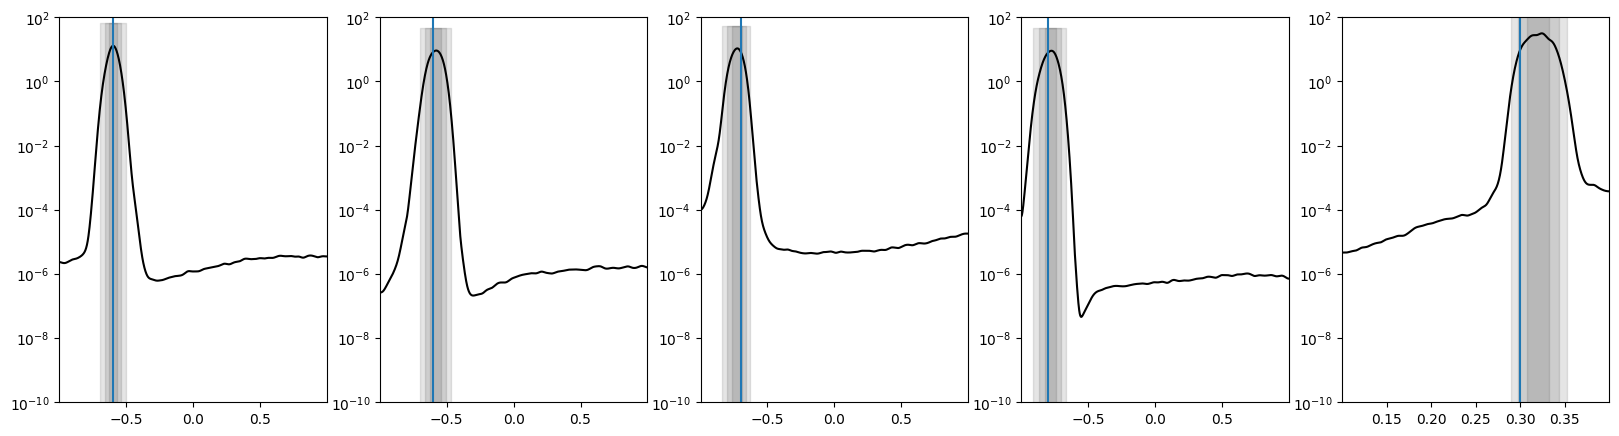

In [37]:
plt.figure(figsize = (20, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    j = i
    swyft.plot_1d(logratios, "z[%i]"%j, ax = plt.gca(), smooth = 10, bins = 1000)
    plt.gca().set_yscale('log')
    plt.gca().set_ylim([1e-10, 1e2])
    plt.axvline(sample0['z'][j])


### Batchnorm, 4 layers, 8k training, no dropout

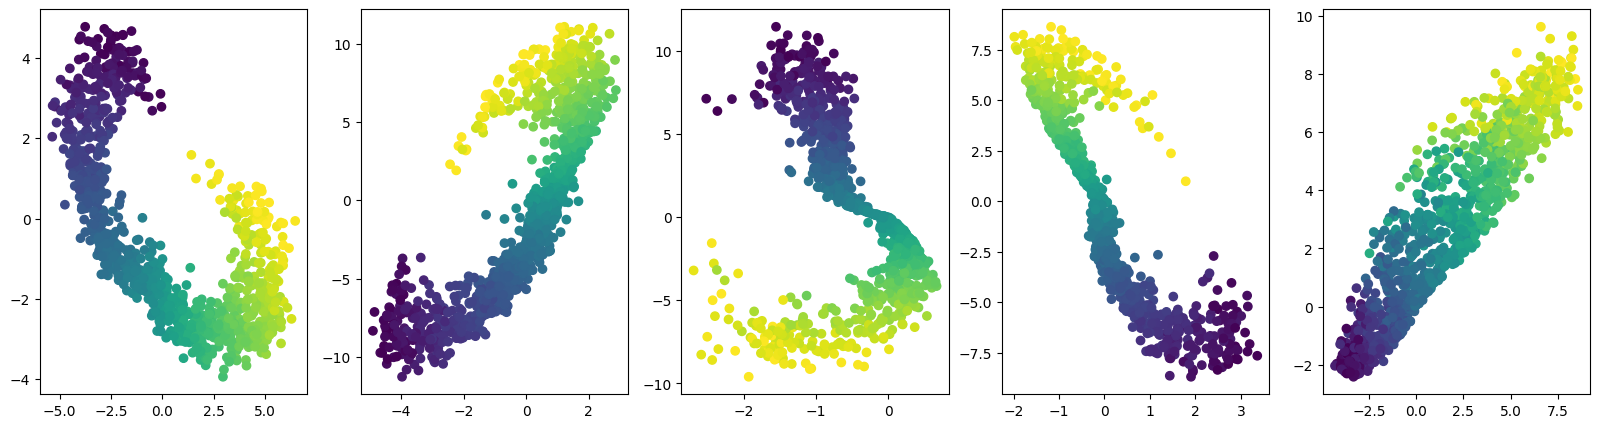

In [9]:
f = logratios2[0][1][:,:]
z = logratios2[0][2]
plt.figure(figsize=(20, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
#    plt.scatter(z[:,i], f[:,i,0])
    plt.scatter(f[:,i,0], f[:,i,1], c = z[:,i])

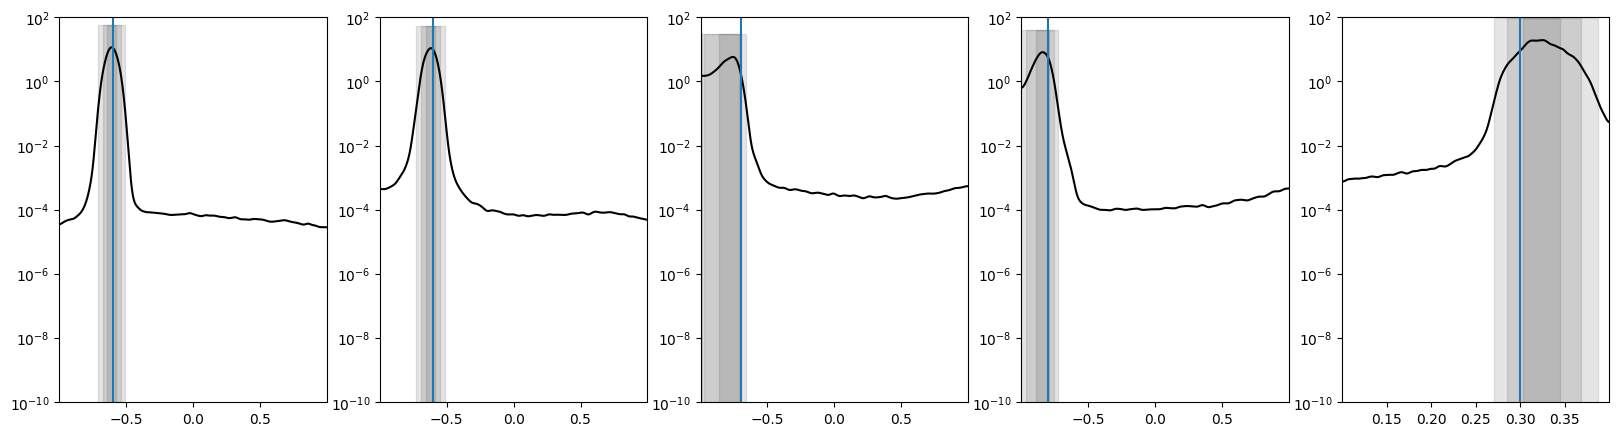

In [10]:
plt.figure(figsize = (20, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    j = i
    swyft.plot_1d(logratios, "z[%i]"%j, ax = plt.gca(), smooth = 10, bins = 1000)
    plt.gca().set_yscale('log')
    plt.gca().set_ylim([1e-10, 1e2])
    plt.axvline(sample0['z'][j])


### Batchnorm, 4 layers, 8k training, no dropout

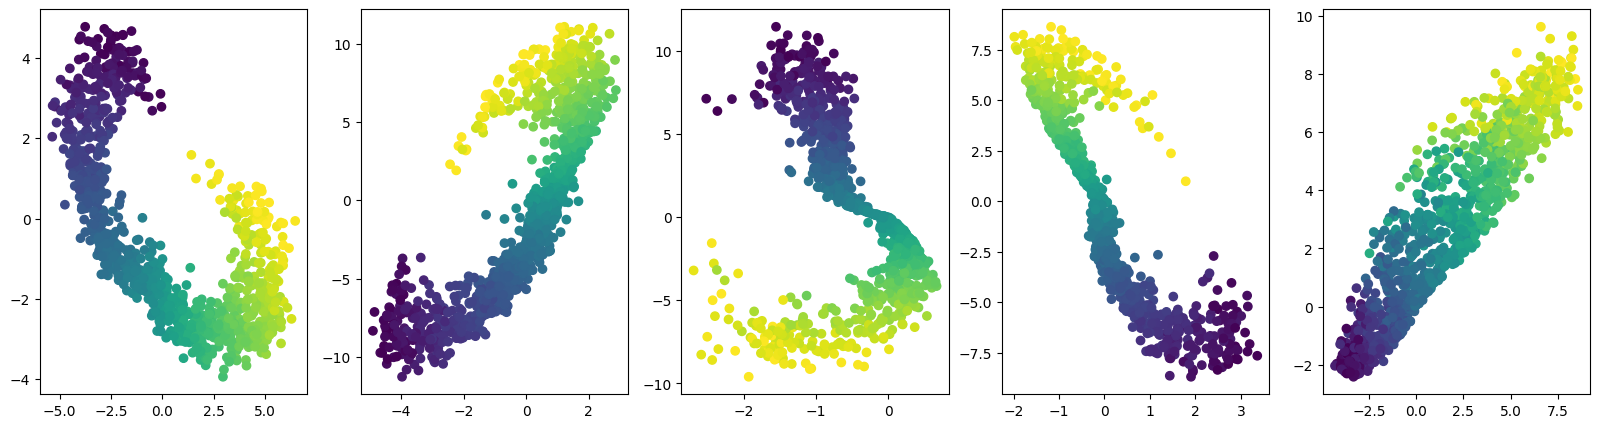

In [9]:
f = logratios2[0][1][:,:]
z = logratios2[0][2]
plt.figure(figsize=(20, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
#    plt.scatter(z[:,i], f[:,i,0])
    plt.scatter(f[:,i,0], f[:,i,1], c = z[:,i])

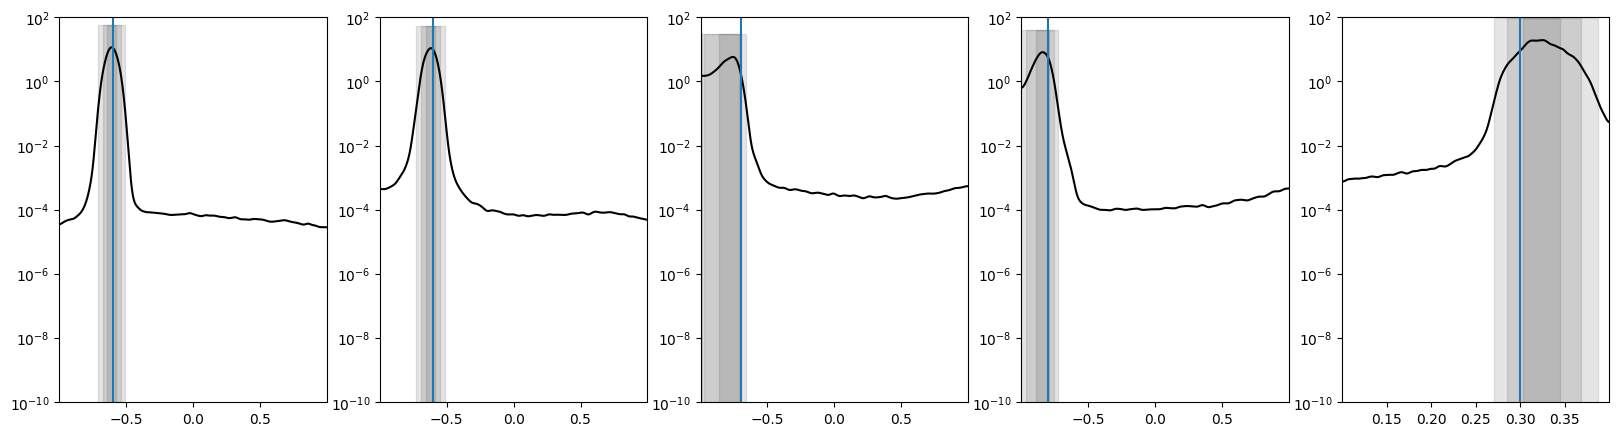

In [10]:
plt.figure(figsize = (20, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    j = i
    swyft.plot_1d(logratios, "z[%i]"%j, ax = plt.gca(), smooth = 10, bins = 1000)
    plt.gca().set_yscale('log')
    plt.gca().set_ylim([1e-10, 1e2])
    plt.axvline(sample0['z'][j])

### Batchnorm, 4 layers, 30k training data

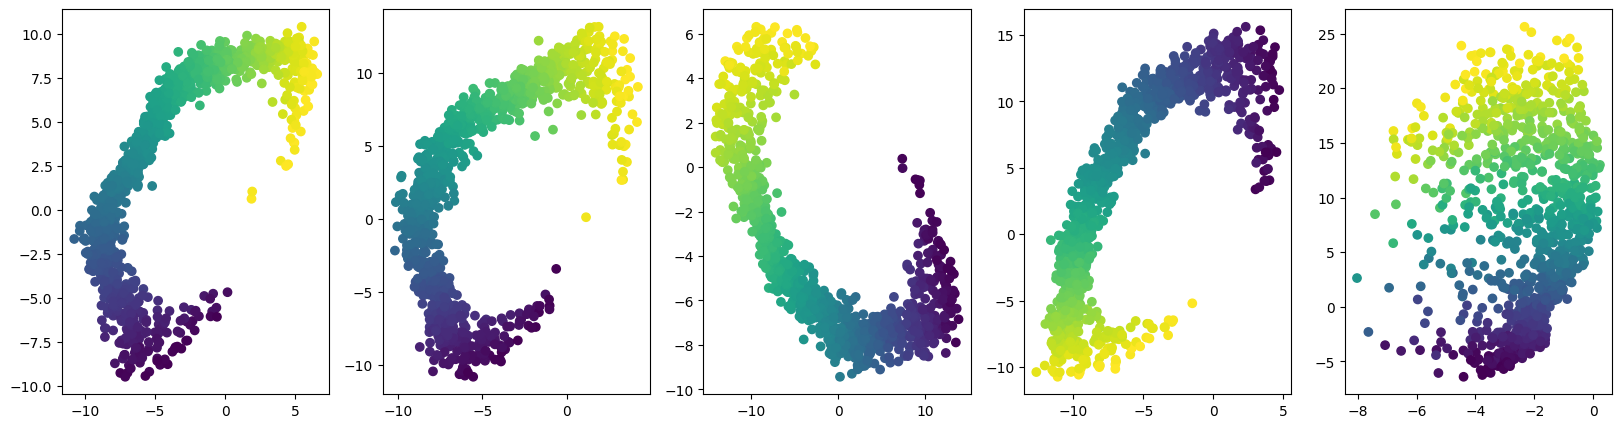

In [34]:
f = logratios2[0][1][:,:]
z = logratios2[0][2]
plt.figure(figsize=(20, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
#    plt.scatter(z[:,i], f[:,i,0])
    plt.scatter(f[:,i,0], f[:,i,1], c = z[:,i])

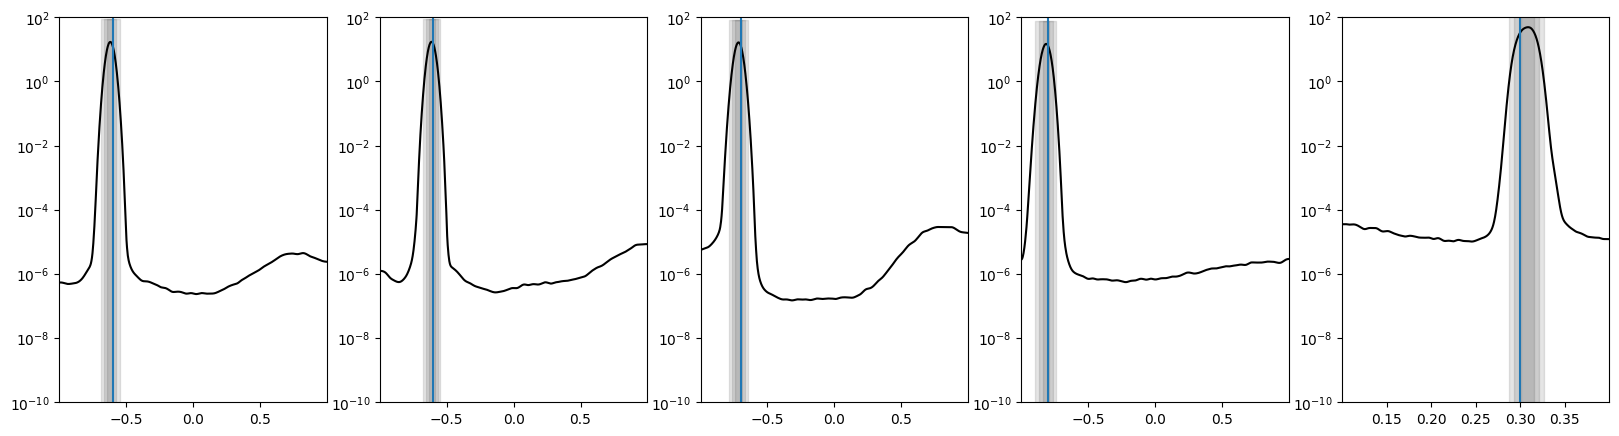

In [36]:
plt.figure(figsize = (20, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    j = i
    swyft.plot_1d(logratios, "z[%i]"%j, ax = plt.gca(), smooth = 10, bins = 1000)
    plt.gca().set_yscale('log')
    plt.gca().set_ylim([1e-10, 1e2])
    plt.axvline(sample0['z'][j])

### Batchnorm, 4 layer

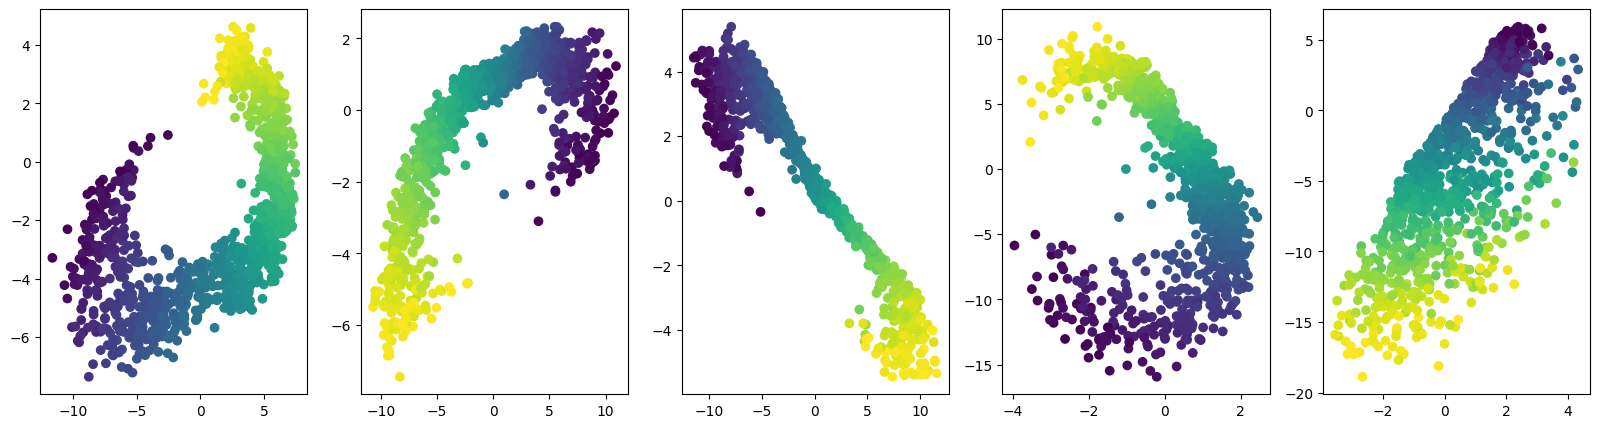

In [29]:
f = logratios2[0][1][:,:]
z = logratios2[0][2]
plt.figure(figsize=(20, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
#    plt.scatter(z[:,i], f[:,i,0])
    plt.scatter(f[:,i,0], f[:,i,1], c = z[:,i])

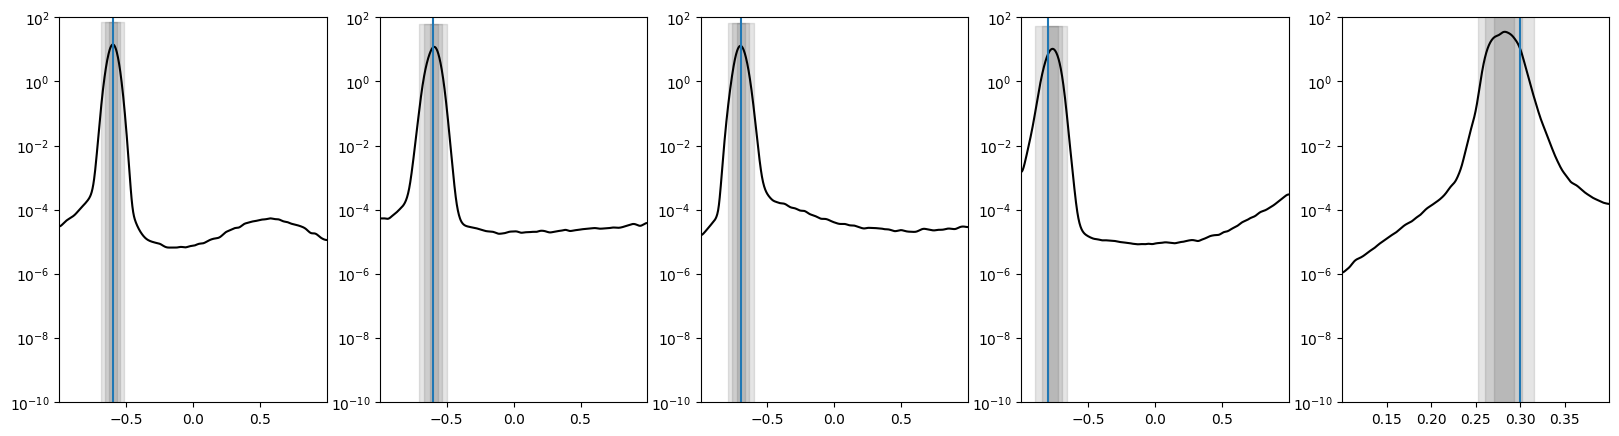

In [30]:
plt.figure(figsize = (20, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    j = i
    swyft.plot_1d(logratios, "z[%i]"%j, ax = plt.gca(), smooth = 10, bins = 1000)
    plt.gca().set_yscale('log')
    plt.gca().set_ylim([1e-10, 1e2])
    plt.axvline(sample0['z'][j])

### 3 Layer, Batchnorm yes

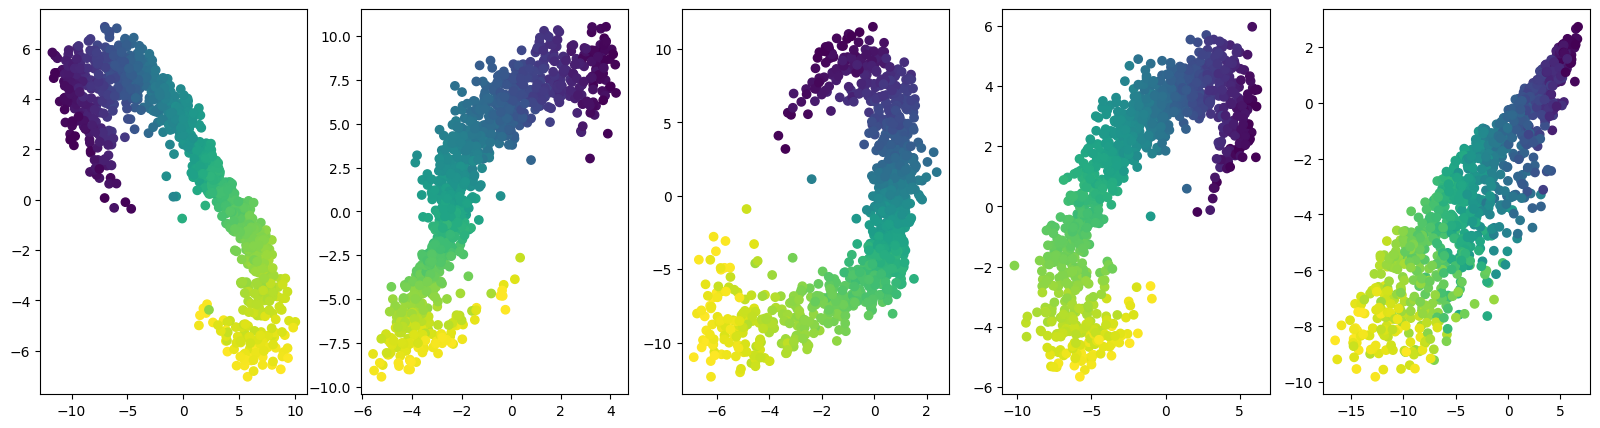

In [22]:
f = logratios2[0][1][:,:]
z = logratios2[0][2]
plt.figure(figsize=(20, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
#    plt.scatter(z[:,i], f[:,i,0])
    plt.scatter(f[:,i,0], f[:,i,1], c = z[:,i])

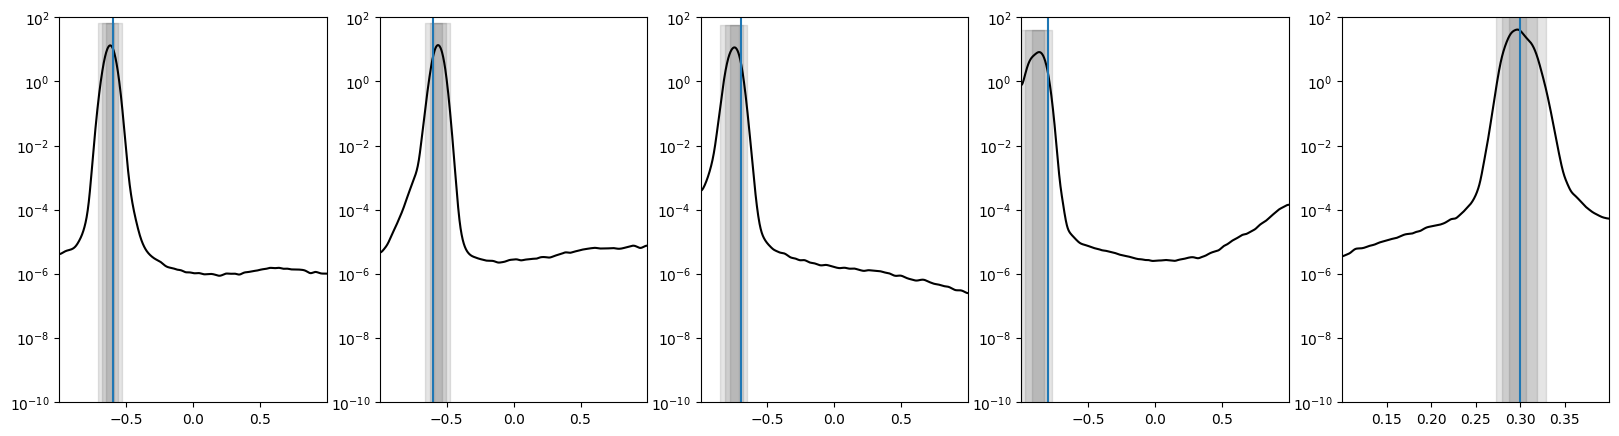

In [23]:
plt.figure(figsize = (20, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    j = i
    swyft.plot_1d(logratios, "z[%i]"%j, ax = plt.gca(), smooth = 10, bins = 1000)
    plt.gca().set_yscale('log')
    plt.gca().set_ylim([1e-10, 1e2])
    plt.axvline(sample0['z'][j])

### 1 Layer, Batchnorm yes

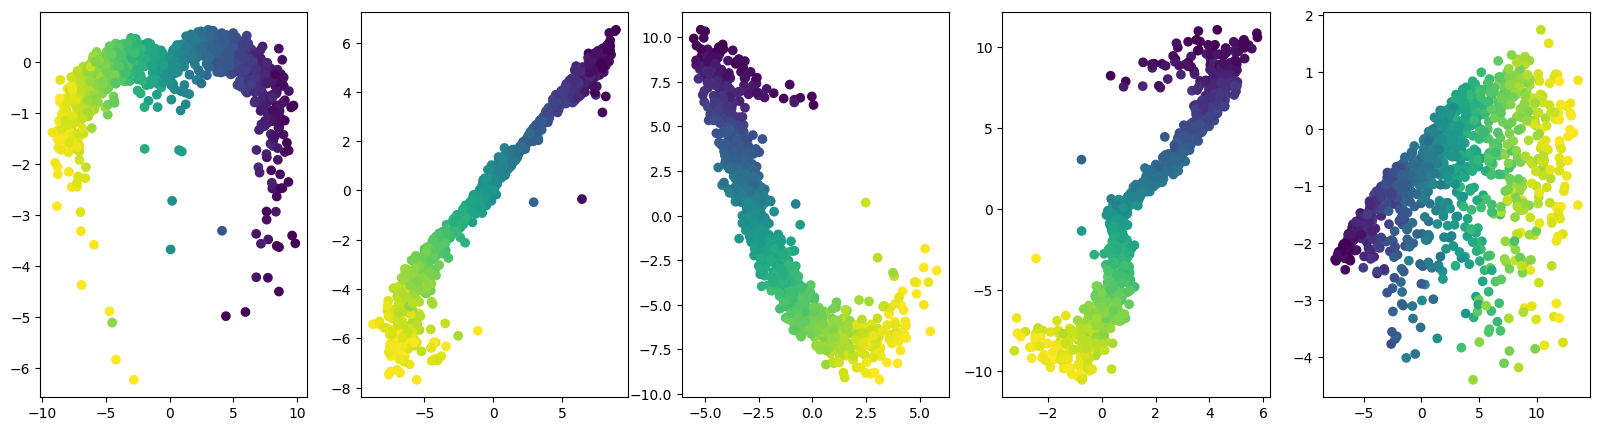

In [17]:
f = logratios2[0][1][:,:]
z = logratios2[0][2]
plt.figure(figsize=(20, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
#    plt.scatter(z[:,i], f[:,i,0])
    plt.scatter(f[:,i,0], f[:,i,1], c = z[:,i])

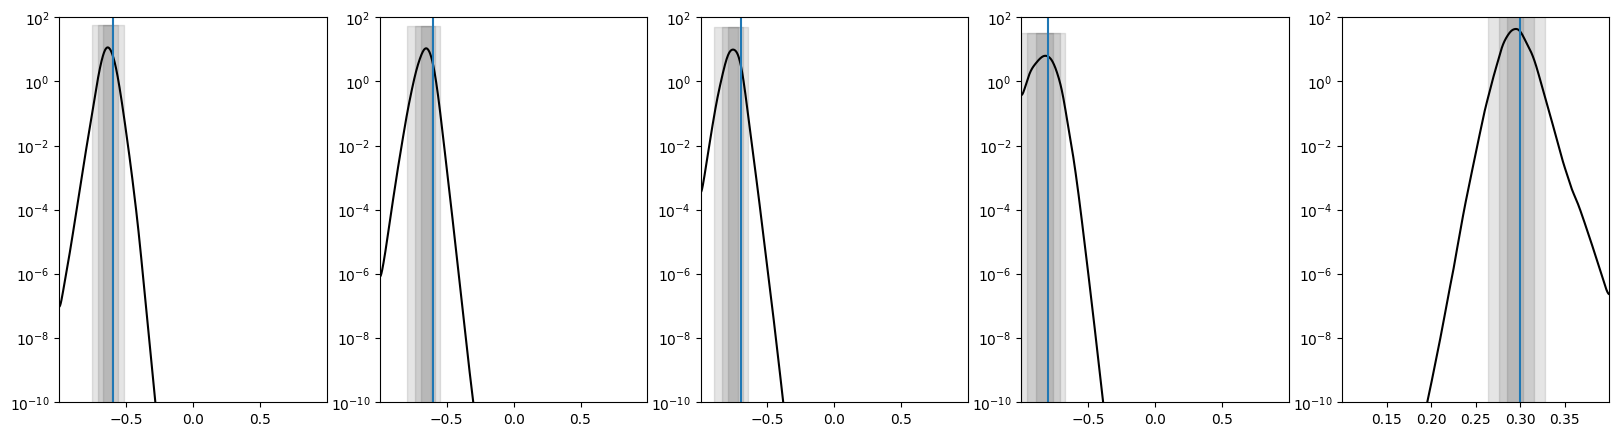

In [18]:
plt.figure(figsize = (20, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    j = i
    swyft.plot_1d(logratios, "z[%i]"%j, ax = plt.gca(), smooth = 10, bins = 1000)
    plt.gca().set_yscale('log')
    plt.gca().set_ylim([1e-10, 1e2])
    plt.axvline(sample0['z'][j])

### Batchnorm, 2 layers

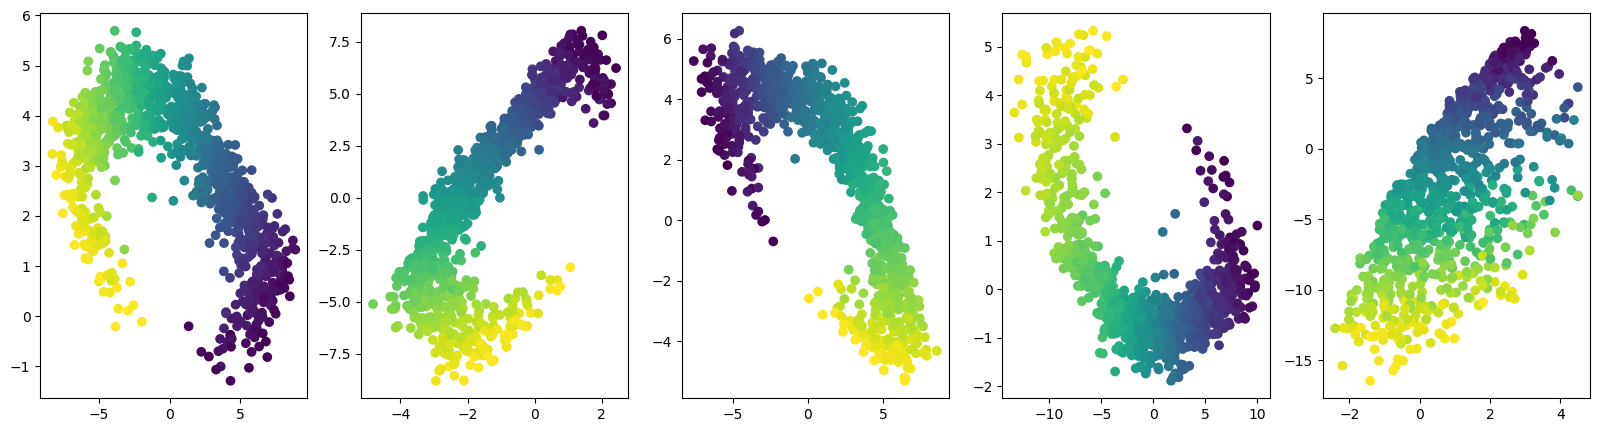

In [12]:
f = logratios2[0][1][:,:]
z = logratios2[0][2]
plt.figure(figsize=(20, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
#    plt.scatter(z[:,i], f[:,i,0])
    plt.scatter(f[:,i,0], f[:,i,1], c = z[:,i])

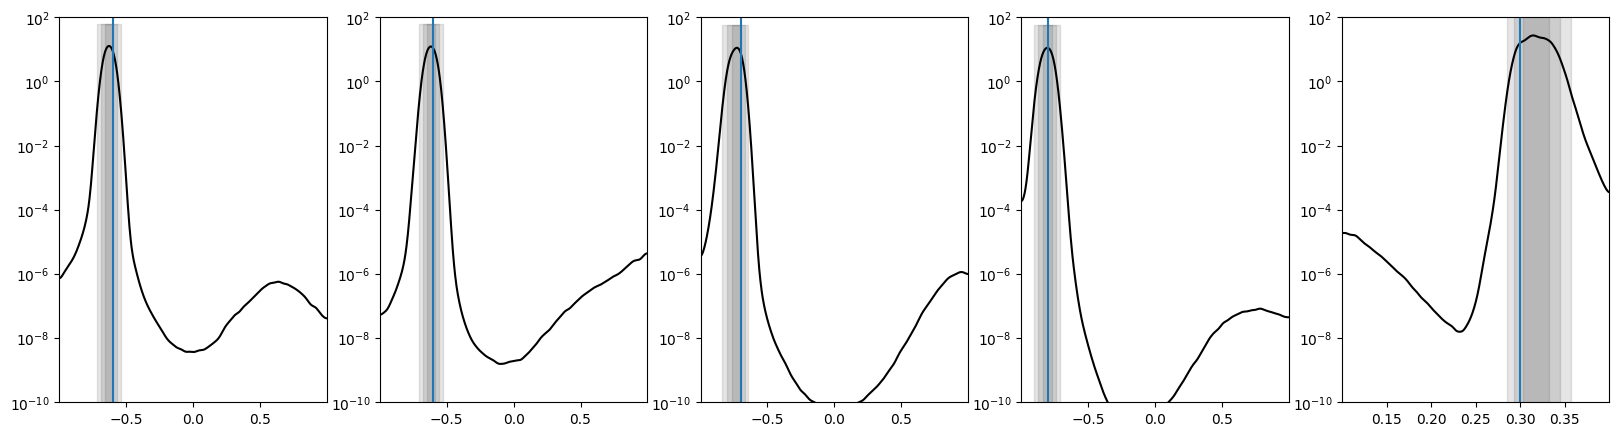

In [13]:
plt.figure(figsize = (20, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    j = i
    swyft.plot_1d(logratios, "z[%i]"%j, ax = plt.gca(), smooth = 10, bins = 1000)
    plt.gca().set_yscale('log')
    plt.gca().set_ylim([1e-10, 1e2])
    plt.axvline(sample0['z'][j])

### 4 features, 80 epochs, minibatch without running averages

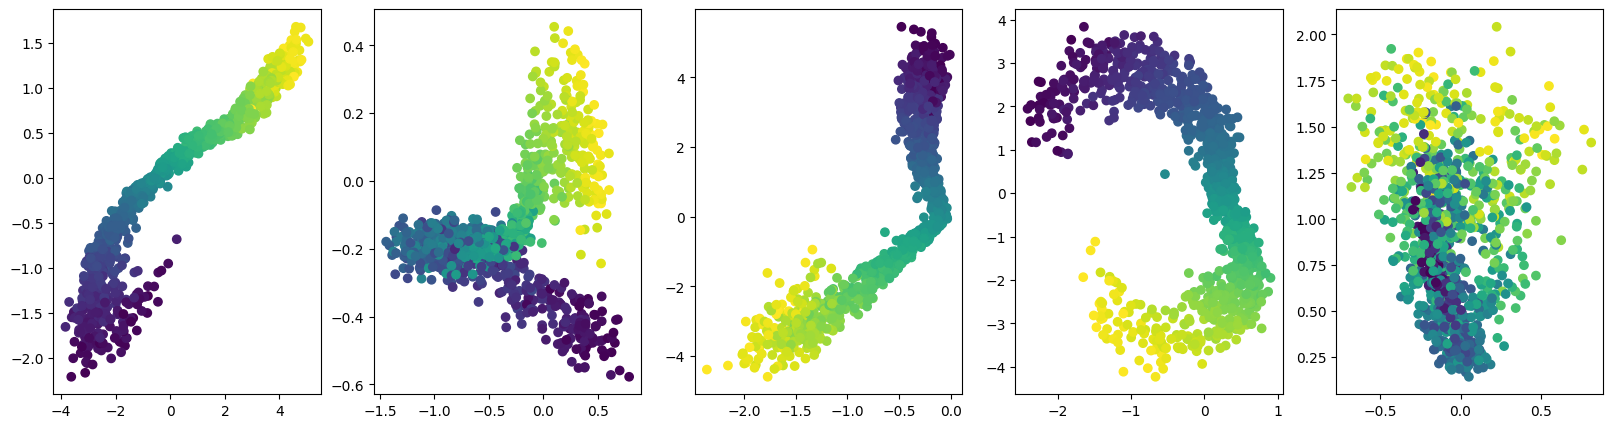

In [57]:
f = logratios2[0][1][:,:]
z = logratios2[0][2]
plt.figure(figsize=(20, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
#    plt.scatter(z[:,i], f[:,i,0])
    plt.scatter(f[:,i,0], f[:,i,1], c = z[:,i])

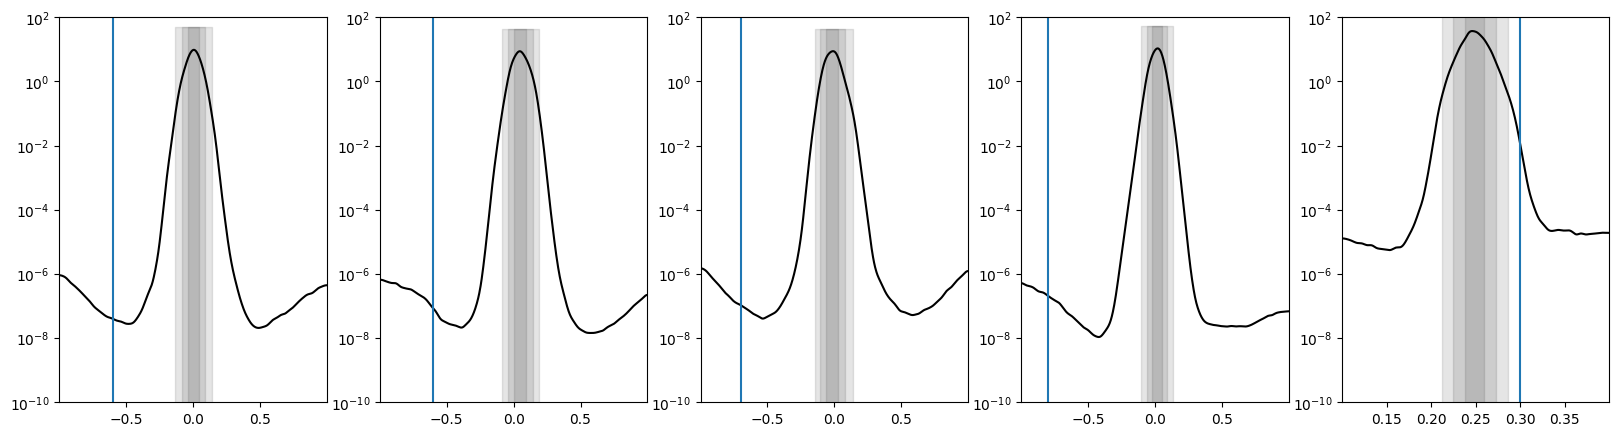

In [58]:
plt.figure(figsize = (20, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    j = i
    swyft.plot_1d(logratios, "z[%i]"%j, ax = plt.gca(), smooth = 10, bins = 1000)
    plt.gca().set_yscale('log')
    plt.gca().set_ylim([1e-10, 1e2])
    plt.axvline(sample0['z'][j])

### Four features, with batchnorm, 80 epochs

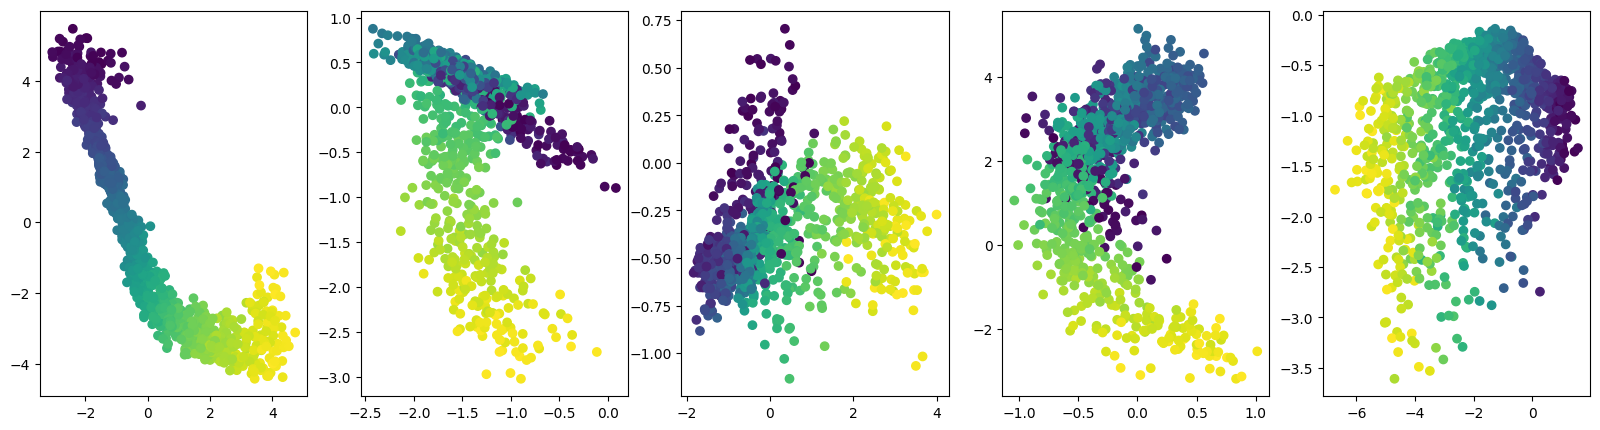

In [49]:
f = logratios2[0][1][:,:]
z = logratios2[0][2]
plt.figure(figsize=(20, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
#    plt.scatter(z[:,i], f[:,i,0])
    plt.scatter(f[:,i,0], f[:,i,1], c = z[:,i])

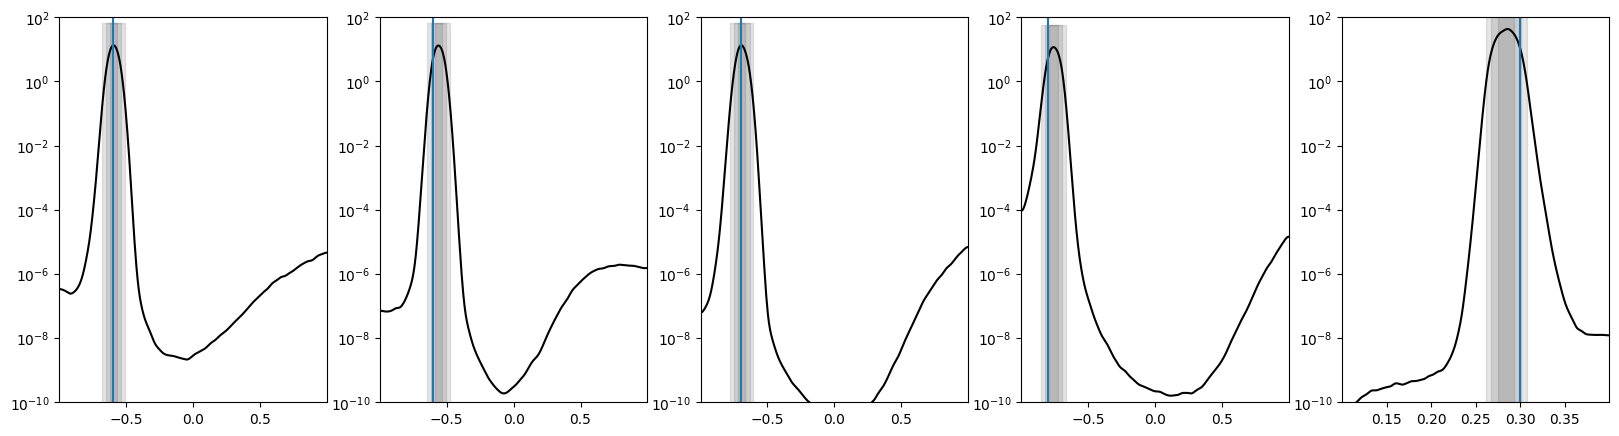

In [50]:
plt.figure(figsize = (20, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    j = i
    swyft.plot_1d(logratios, "z[%i]"%j, ax = plt.gca(), smooth = 10, bins = 1000)
    plt.gca().set_yscale('log')
    plt.gca().set_ylim([1e-10, 1e2])
    plt.axvline(sample0['z'][j])

89.44271909999159

### Four features, without batchnorm, 80 epochs

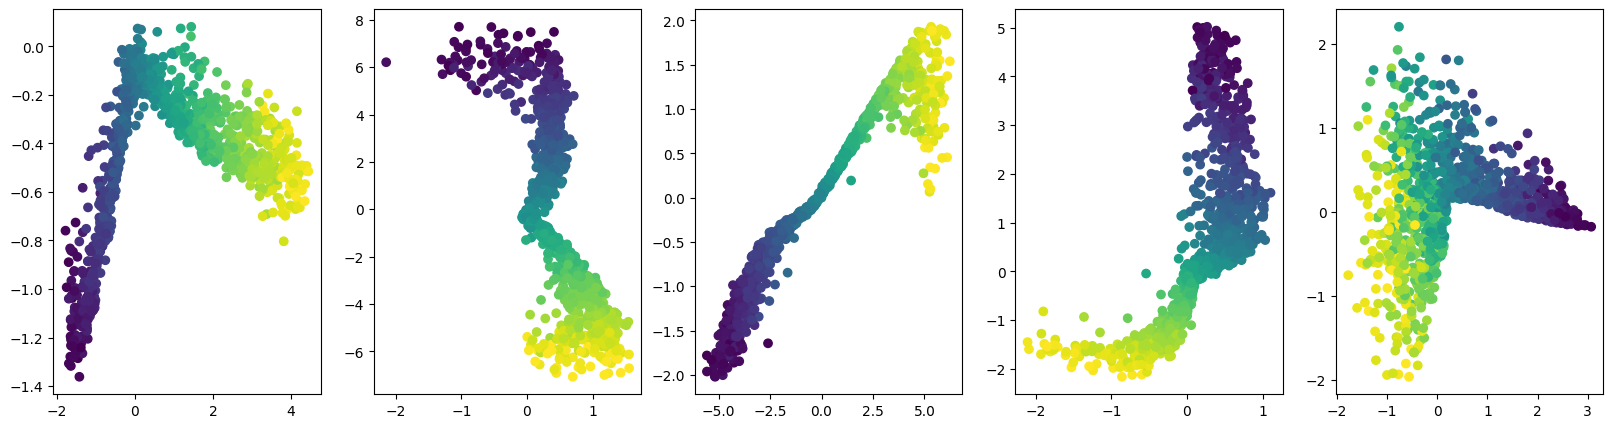

In [40]:
f = logratios2[0][1][:,:]
z = logratios2[0][2]
plt.figure(figsize=(20, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
#    plt.scatter(z[:,i], f[:,i,0])
    plt.scatter(f[:,i,0], f[:,i,1], c = z[:,i])

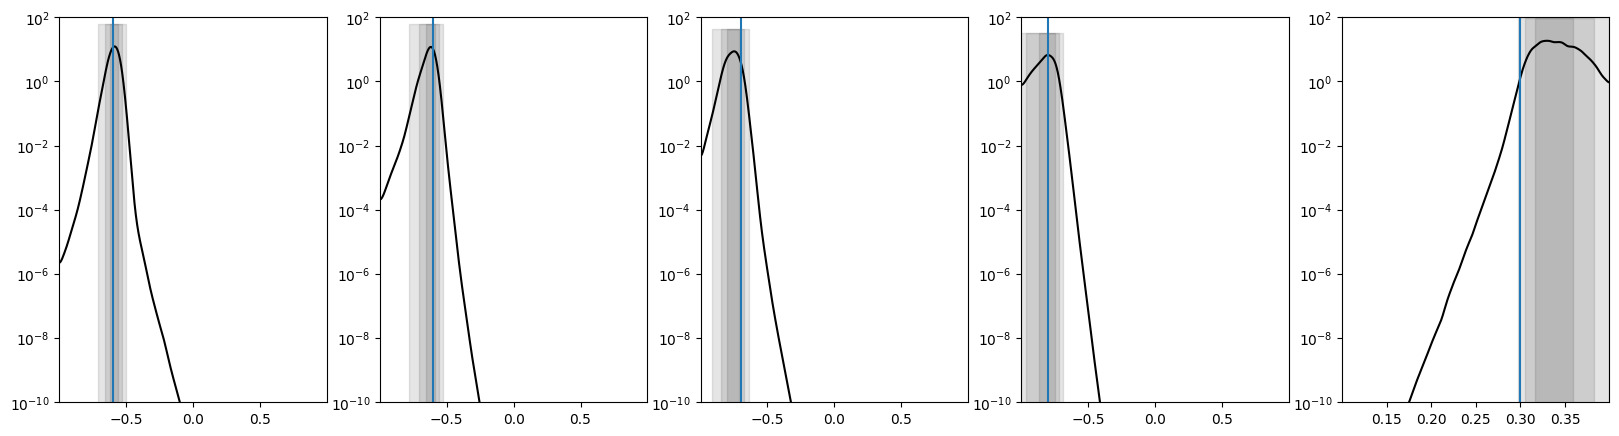

In [41]:
plt.figure(figsize = (20, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    j = i
    swyft.plot_1d(logratios, "z[%i]"%j, ax = plt.gca(), smooth = 10, bins = 1000)
    plt.gca().set_yscale('log')
    plt.gca().set_ylim([1e-10, 1e2])
    plt.axvline(sample0['z'][j])

### Four features without batchnorm

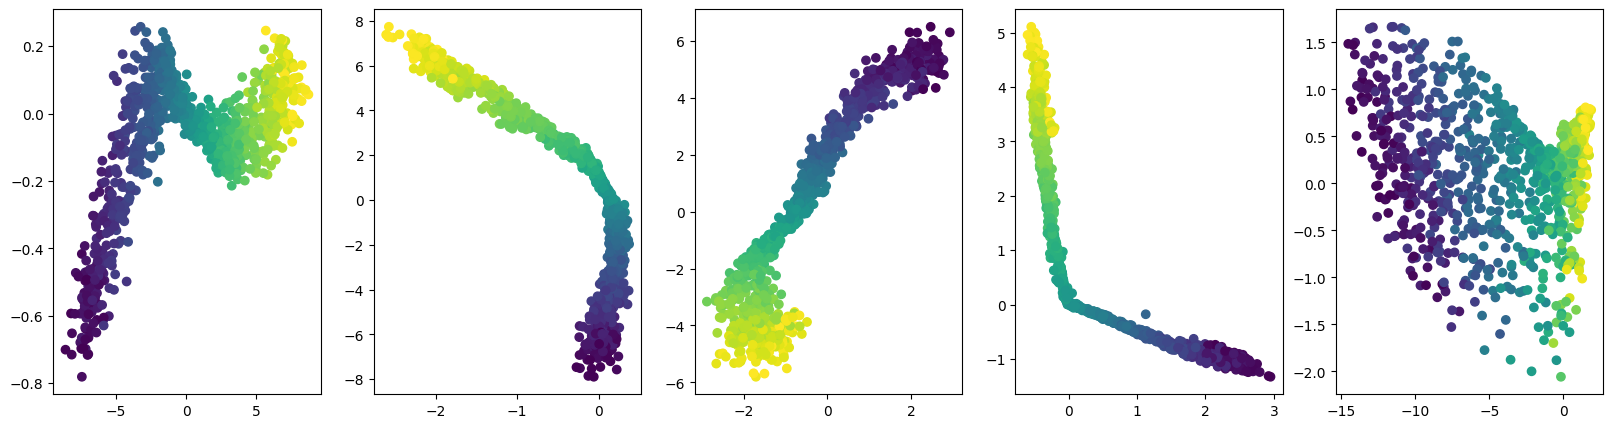

In [35]:
f = logratios2[0][1][:,:]
z = logratios2[0][2]
plt.figure(figsize=(20, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
#    plt.scatter(z[:,i], f[:,i,0])
    plt.scatter(f[:,i,0], f[:,i,1], c = z[:,i])

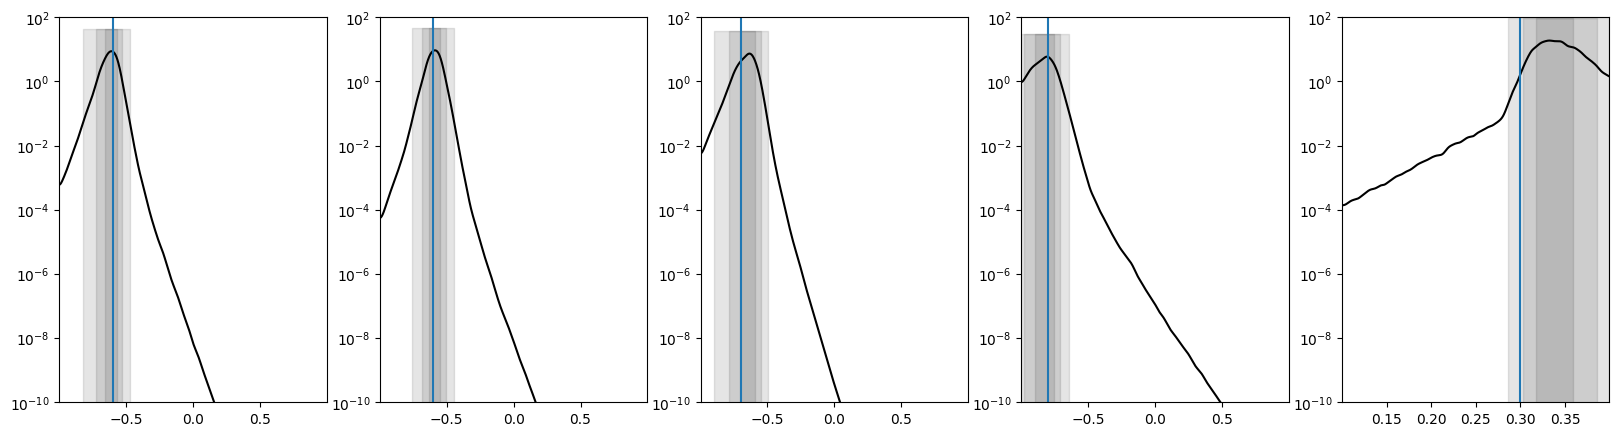

In [36]:
plt.figure(figsize = (20, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    j = i
    swyft.plot_1d(logratios, "z[%i]"%j, ax = plt.gca(), smooth = 10, bins = 1000)
    plt.gca().set_yscale('log')
    plt.gca().set_ylim([1e-10, 1e2])
    plt.axvline(sample0['z'][j])

### One features without batchnorm

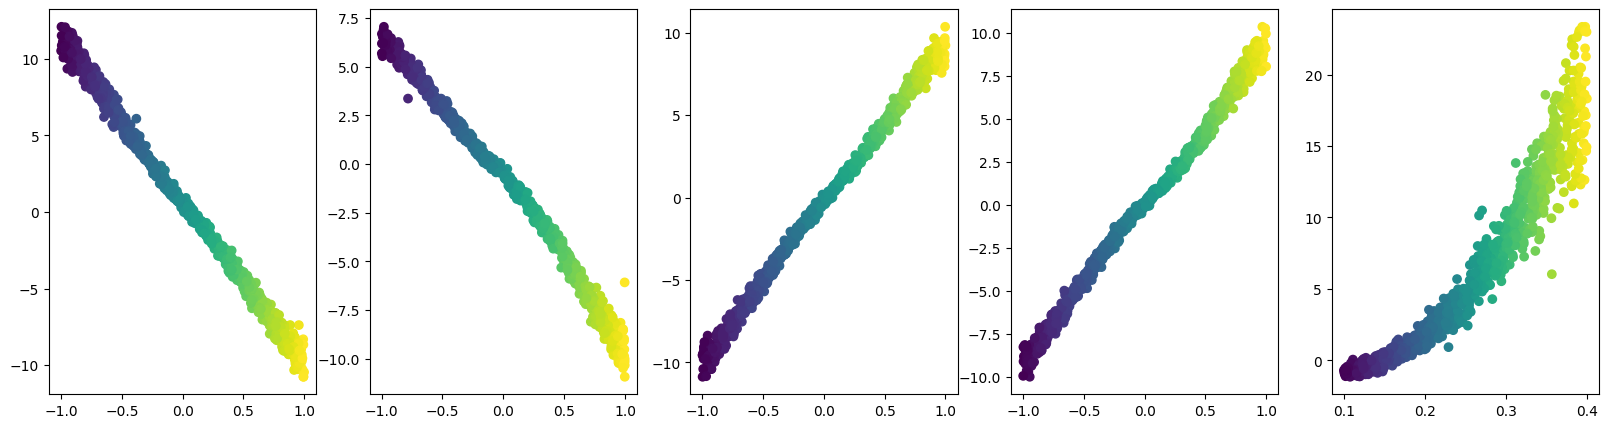

In [31]:
f = logratios2[0][1][:,:]
z = logratios2[0][2]
plt.figure(figsize=(20, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
#    plt.scatter(z[:,i], f[:,i,0])
    plt.scatter(z[:,i], f[:,i,0], c = z[:,i])

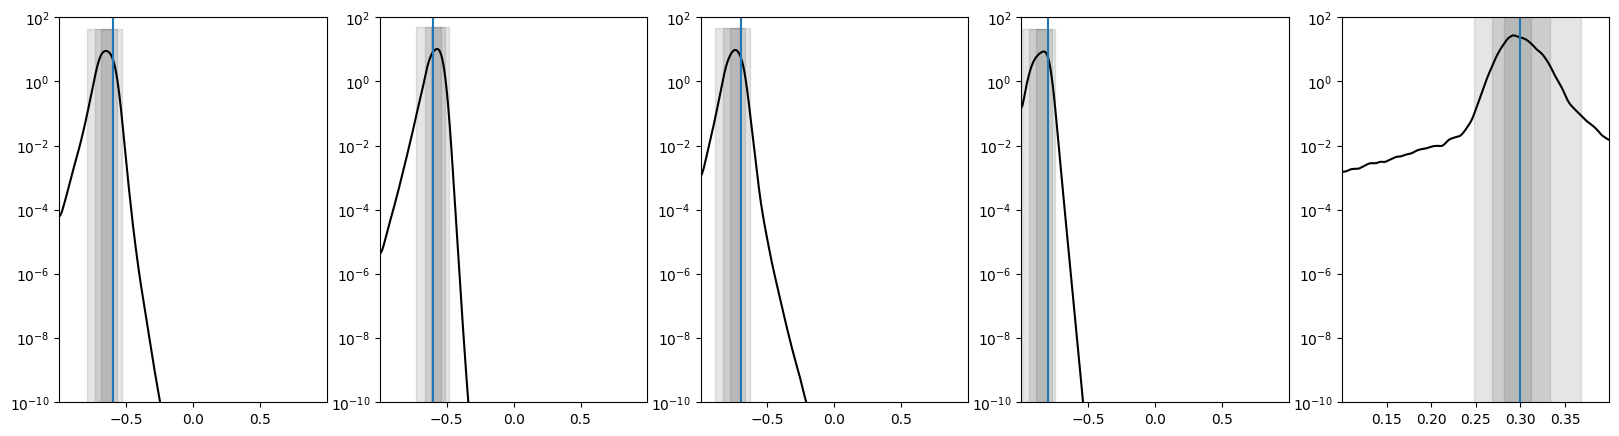

In [28]:
plt.figure(figsize = (20, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    j = i
    swyft.plot_1d(logratios, "z[%i]"%j, ax = plt.gca(), smooth = 10, bins = 1000)
    plt.gca().set_yscale('log')
    plt.gca().set_ylim([1e-10, 1e2])
    plt.axvline(sample0['z'][j])

### One feature, with batchnorm

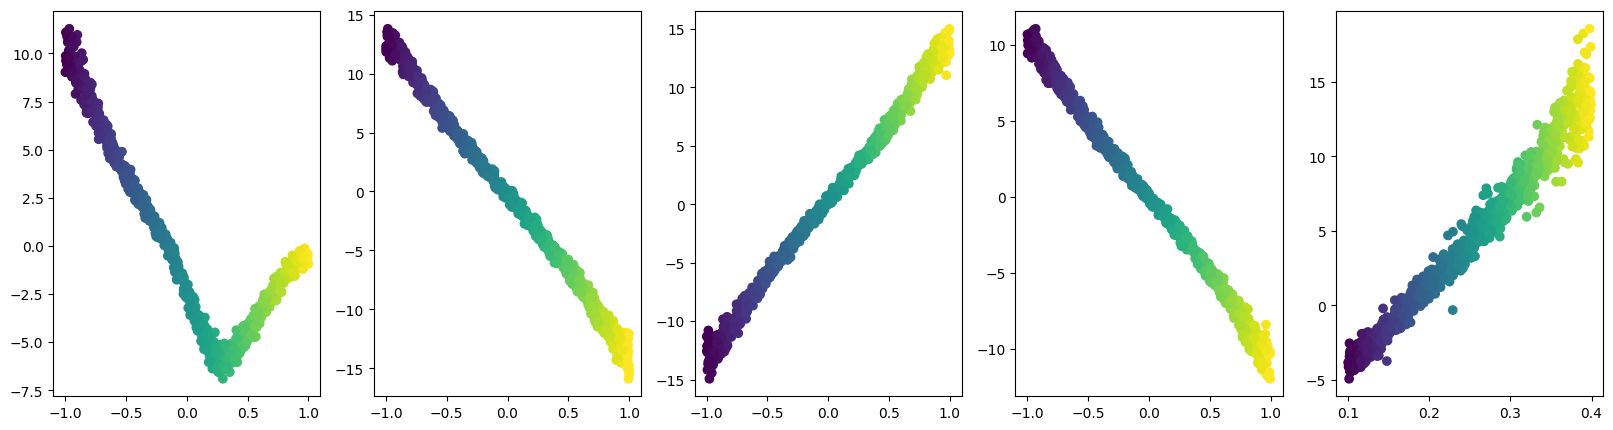

In [22]:
f = logratios2[0][1][:,:]
z = logratios2[0][2]
plt.figure(figsize=(20, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
#    plt.scatter(z[:,i], f[:,i,0])
    plt.scatter(z[:,i], f[:,i,0], c = z[:,i])

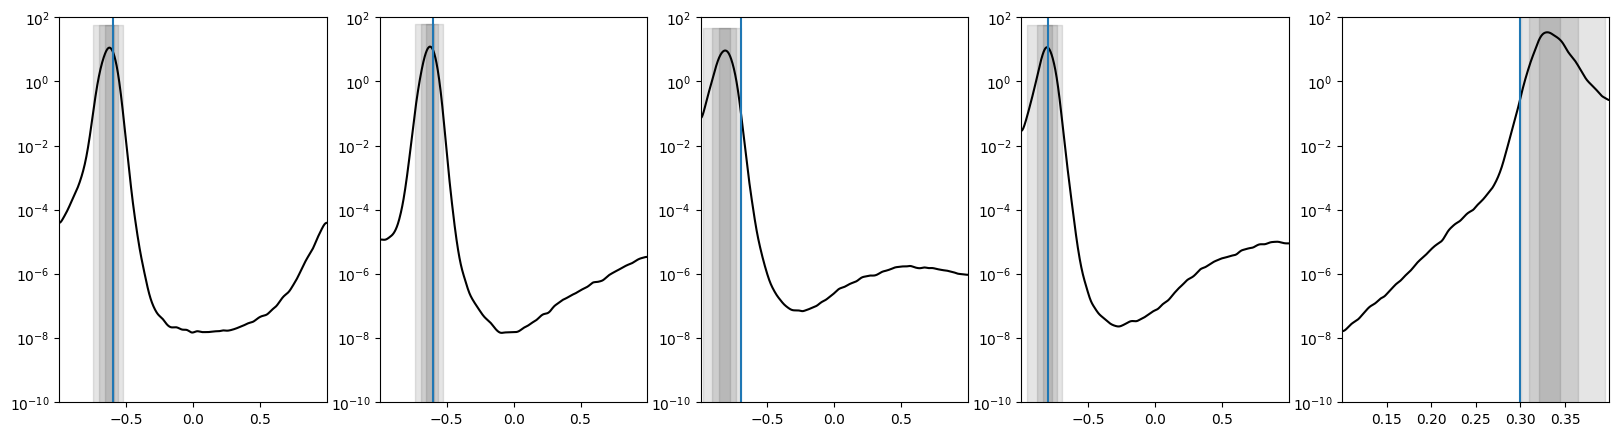

In [23]:
plt.figure(figsize = (20, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    j = i
    swyft.plot_1d(logratios, "z[%i]"%j, ax = plt.gca(), smooth = 10, bins = 1000)
    plt.gca().set_yscale('log')
    plt.gca().set_ylim([1e-10, 1e2])
    plt.axvline(sample0['z'][j])

### Two features, with batchnorm

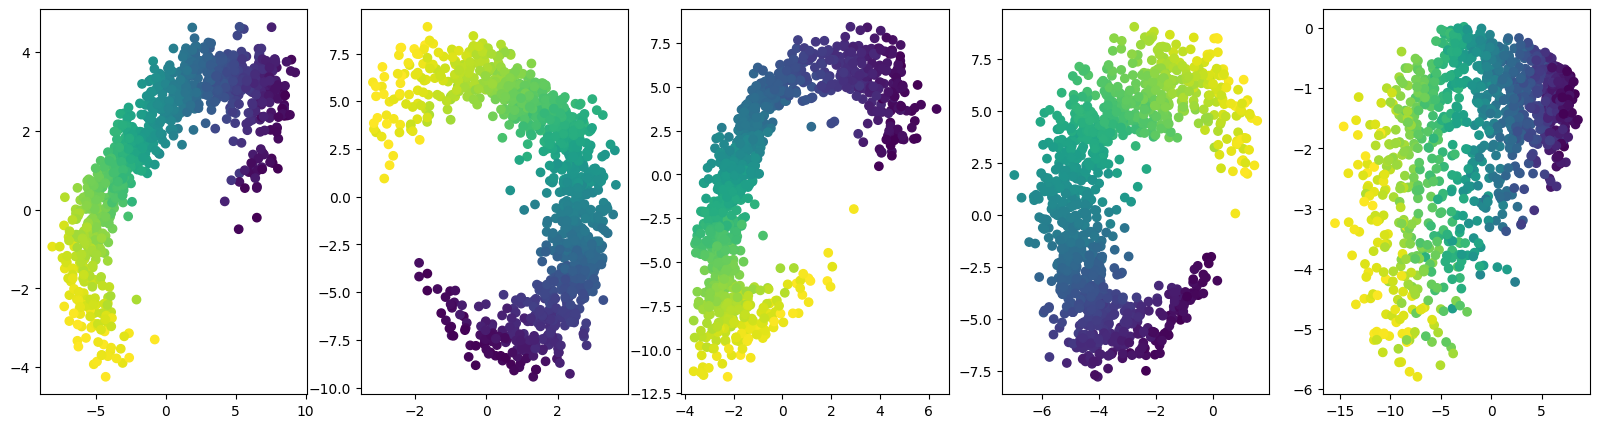

In [16]:
f = logratios2[0][1][:,:]
z = logratios2[0][2]
plt.figure(figsize=(20, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
#    plt.scatter(z[:,i], f[:,i,0])
    plt.scatter(f[:,i,0], f[:,i,1], c = z[:,i])

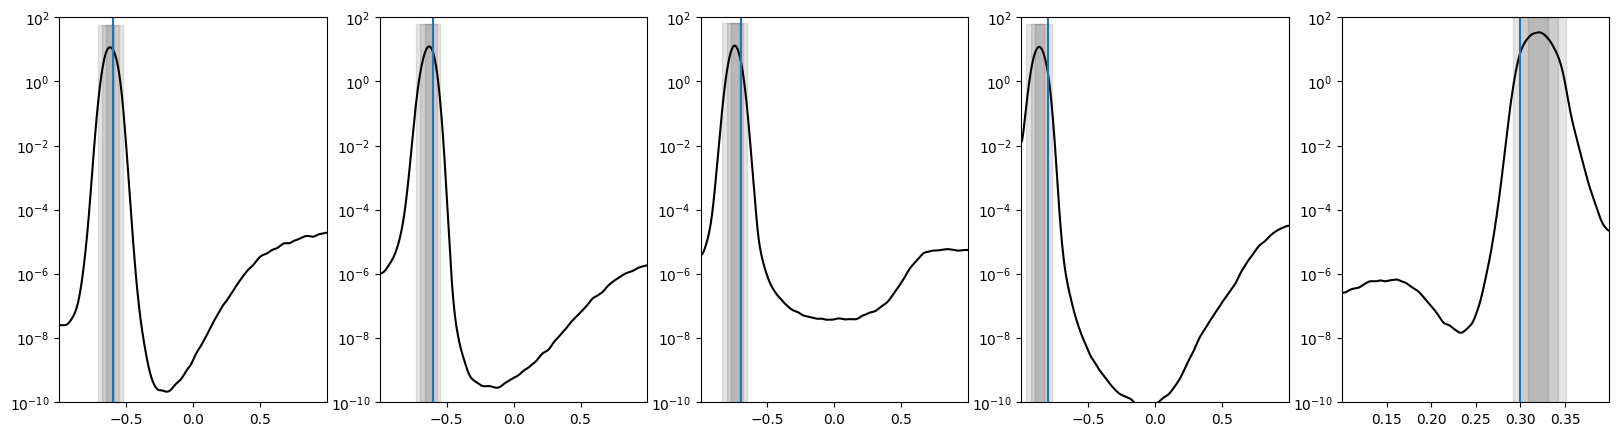

In [17]:
plt.figure(figsize = (20, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    j = i
    swyft.plot_1d(logratios, "z[%i]"%j, ax = plt.gca(), smooth = 10, bins = 1000)
    plt.gca().set_yscale('log')
    plt.gca().set_ylim([1e-10, 1e2])
    plt.axvline(sample0['z'][j])

### Get constraints

tensor([[-0.6033, -0.5963],
        [-0.6036, -0.5968],
        [-0.7027, -0.6943],
        [-0.8057, -0.7797],
        [ 0.2979,  0.3022]])


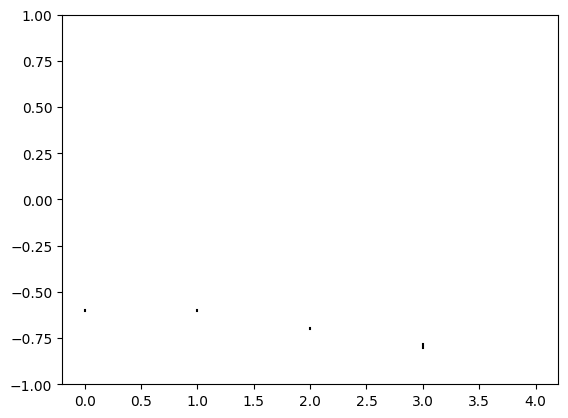

In [317]:
def get_constr(logratios, params, threshold = 1e-6):
    l = logratios
    p = params
    l_max = l.max(0).values
    dl = l - l_max
    w = torch.exp(dl)
    w = w/w.sum(0)
    ws = w.sort(dim=0).values
    wsc = torch.cumsum(ws, 0)
    th = threshold
    w_th = (ws + (wsc < th)).min(0).values
    mask = w >= w_th
    par_max = p.max(dim=0).values
    par_min = p.min(dim=0).values
    constr_min = torch.where(mask.unsqueeze(-1), p, par_max).min(dim=0).values
    constr_max = torch.where(mask.unsqueeze(-1), p, par_min).max(dim=0).values
    return torch.stack([constr_min, constr_max], dim=-1)


bounds = get_constr(logratios[0].logratios, logratios[0].params, 1e-4)[:,0,:]
for i, b in enumerate(bounds):
    plt.plot([i, i], b, 'k')
plt.ylim([-1, 1])
print(bounds)